In [540]:
import pandas as pd
import numpy as np
%matplotlib inline
import os
import matplotlib.pyplot as plt
from geopy.distance import great_circle
from datetime import datetime,timedelta
import seaborn as sns


In [541]:
# Импортируем датасет, смотрим на колонки и типы данных

df = pd.read_csv('AAQ_flights.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   flight_id          193 non-null    int64  
 1   flight_no          193 non-null    object 
 2   departure_airport  193 non-null    object 
 3   dep_longitude      193 non-null    float64
 4   dep_latitude       193 non-null    float64
 5   arrival_airport    193 non-null    object 
 6   airport_name       193 non-null    object 
 7   actual_departure   193 non-null    object 
 8   actual_arrival     193 non-null    object 
 9   duration           193 non-null    object 
 10  city               193 non-null    object 
 11  arrival_longitude  193 non-null    float64
 12  arrival_latitude   193 non-null    float64
 13  timezone           193 non-null    object 
 14  model              193 non-null    object 
 15  range              193 non-null    int64  
 16  ticket_price       180 non

In [542]:
#Заполним все значения NaN нулями, потому что NaN в ticket_price означают нули
df = df.fillna(0)

In [543]:
# Для начала приведем дату и время в вид timestamp и timedelta, удалим старые колонки

df['departure_time'] = df.actual_departure.apply(lambda x: datetime.strptime(x,'%Y-%m-%dT%H:%M:%SZ'))
df['arrival_time'] = df.actual_arrival.apply(lambda x: datetime.strptime(x,'%Y-%m-%dT%H:%M:%SZ'))

df = df.drop(['actual_departure','actual_arrival'], axis = 1)

# Заново пересчитаем длительность полета, перезапишем в колонку  duration

df.duration = df['arrival_time'] - df['departure_time']


In [544]:
# Проверим, сколько аэропортов назначения в нашем датасете:
df.arrival_airport.value_counts()

EGO    90
SVO    90
NOZ    13
Name: arrival_airport, dtype: int64

In [545]:
# Найдем из открытых источников летное расстояние между аэропортом вылета (AAQ) и аэропортами прилета
all_distances = {
                'SVO':1221, 
                'EGO':700, 
                'NOZ':3633
                }

# Добавим в датасет полученные расстояния
df['distance'] = df.arrival_airport.map(all_distances)

In [546]:
# Приступим к расчету расхода на топливо. Сначала найдем расход топлива каждого вида самолета в датасете
df.model.value_counts()

Boeing 737-300         103
Sukhoi Superjet-100     90
Name: model, dtype: int64

In [547]:
# Как видно, у нас два вида самолета. Найдем расход топлива каждого из них в документации:

all_fuel_consumption_kgph = {
                        'Boeing 737-300': 2500,
                        'Sukhoi Superjet-100':1700
                        }

In [548]:
# Добавим стоимость топлива в аэропорту Анапы по месяцам:

AAQ_fuel_prices_per_t = {
                'December': 47101,
                'January': 41435,
                'February': 41435
                }

In [549]:
# Рассчитаем затраты на перелет с учетом расхода топлива, длительности перелета и стоимости тонны топливаЖ

df['departure_month'] = df.departure_time.apply(lambda x: datetime.strftime(x, '%B'))
df['departure_day'] = df.departure_time.apply(lambda x: datetime.strftime(x, '%A'))
df['fuel_price_per_t'] = df.departure_month.map(AAQ_fuel_prices_per_t)
#df = df.drop('departure_month', axis = 1)

df['fuel_cost'] = df.fuel_price_per_t * df.model.map(all_fuel_consumption_kgph)/1000 * df.duration/timedelta(hours=1)
df['fuel_cost'] = round(df['fuel_cost'],0)
df = df.drop(['fuel_price_per_t'], axis = 1)

# Удалим уже ненужные колонки из таблицы:

df = df.drop(['city','airport_name','dep_longitude','dep_latitude',
              'arrival_longitude','arrival_latitude','timezone'], axis = 1)

In [550]:
# Масимальная взлетная масса самолетов:

maximum_weight_flight = {'Boeing 737-300':56472,
                        'Sukhoi Superjet-100':45880}

# Добавим в датасет, так как этот параметр используется для расчета аэропортовых сборов
df['max_flight_weight'] = df.model.map(maximum_weight_flight)

In [551]:
# Напишем функцию для расчета аэропортовых сборов

def airport_fare(row):
    # При вылете из Анапы во всех направлениях также необходимо оплатить обслуживание в аэропорту AAQ. 
    # Эти затраты будем добавлять в концу к каждому рейсу
    
    if row['arrival_airport'] == 'EGO':
        fares = row['max_flight_weight']/1000 * (833 + 376 + 408) \
                + row['seats_occupied'] * (167 + 104) +  7560 + 2500 \
                
    elif row['arrival_airport'] == 'SVO':
        fares = row['seats_occupied'] * 194 \
                + 5164+ 87*120 + 7400 + 4100 + 3500 + 1300 + 5884 + 5413 + 3274 + 36105 + 3838 + 1880 + 1953 + 440
    
    elif row['arrival_airport'] == 'NOZ':
        
        dep_arrival_fee = 659
        security_fee = 303.7
        passenger_fee = 132
        meteo_fee = 5040
        passenger_service = 221
        luggage_service_per_pass = 90
        boarding_fee = 4000 + 3000
        
        fares = row['seats_occupied'] * (passenger_fee + passenger_service + luggage_service_per_pass) \
                + row['max_flight_weight']/1000 * (dep_arrival_fee + security_fee) + boarding_fee + meteo_fee
    
    # К сборам аэропортов прилета добавим сборы аэропорта Анапы
    AAQ_depart_fee = 412
    AAQ_security_fee = 317
    AAQ_passenger_fee = 66
    AAQ_passenger_service = 165
    
    return fares + row['max_flight_weight']/1000 * (AAQ_depart_fee + AAQ_security_fee + 408) \
            + row['seats_occupied'] * (AAQ_passenger_fee + AAQ_passenger_service)

In [552]:
# Рассчитаем с использованием функции сборы в аэропортах, добавим в датасет.
df['airport_fares'] = df.apply(lambda row: airport_fare(row), axis=1) 

In [553]:
# Добавим к расходам также расходы на питание. Возьмем в среднем $10 на пассажира, или 600 рублей.
df.airport_fares = df.airport_fares + df.seats_occupied * 600

In [554]:
# Посчитаем заполняемость самолета 
df['occupancy'] = df.seats_occupied/df.seats_total

In [555]:
# Рассчитаем прибыль путем вычитания затрат на топливо, аэропортовых сборов и налога НДС из общей стоимости билетов.
VAT = 0.1

df['revenue'] = round((df['ticket_price']*(1 - VAT) - df.fuel_cost - df.airport_fares),0)
df.revenue = df.revenue.fillna(0)

In [556]:
df.departure_month.value_counts()

January     67
December    66
February    60
Name: departure_month, dtype: int64

Приступим к построению графиков.

/Users/ktaov/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/ktaov/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/ktaov/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


<Figure size 1152x432 with 0 Axes>

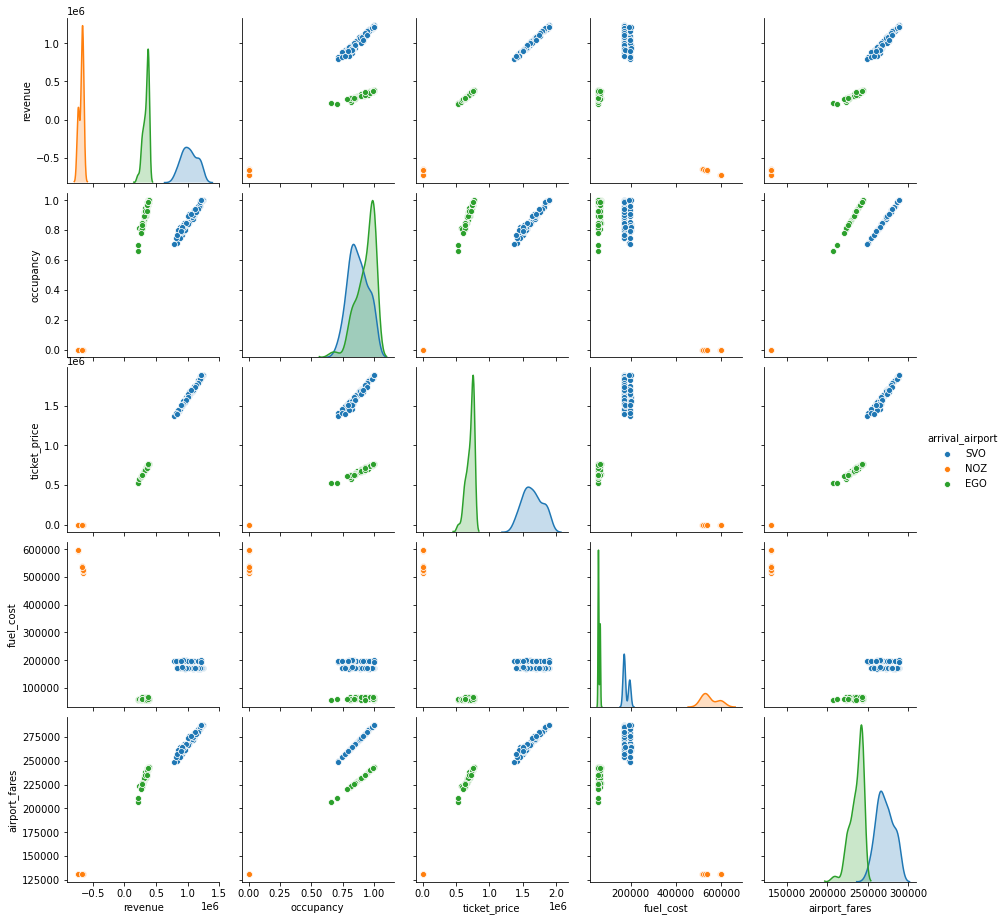

In [557]:
# Посмотрим, как влияют на основные параметры аэропорты вылета.

plt.figure(figsize = (16,6))

sns.pairplot(df[['revenue',
                 'occupancy',
                 'ticket_price',
                 'fuel_cost',
                 'arrival_airport',
                 'airport_fares']] , 
             hue = "arrival_airport")

plt.savefig('pairplot.png', dpi=300, bbox_inches='tight')

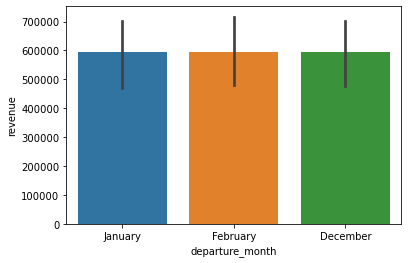

In [558]:
# Рассмотрим зависимость прибыли от месяца вылета
sns.barplot(data = df, x = 'departure_month', y = 'revenue')

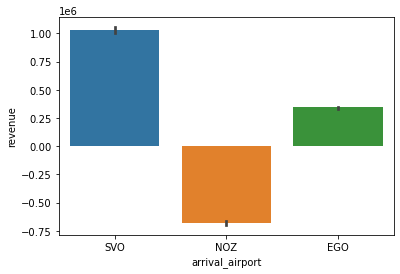

In [559]:
# Рассмотрим зависимость прибыли от аэропорта
sns.barplot(data = df, x = 'arrival_airport', y = 'revenue')

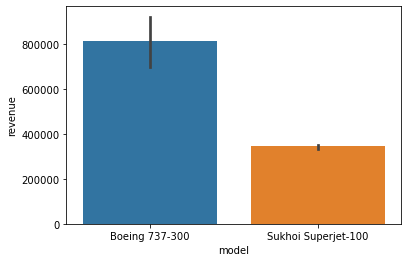

In [560]:
# Рассмотрим зависимость прибыли от модели самолета
sns.barplot(data = df, x = 'model', y = 'revenue')

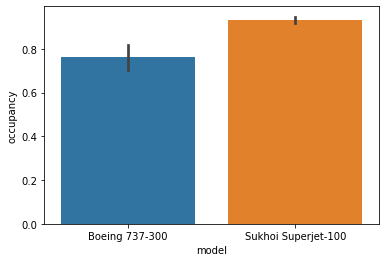

In [561]:
# Рассмотрим зависимость заполняемости от модели самолета
sns.barplot(data = df, x = 'model', y = 'occupancy')

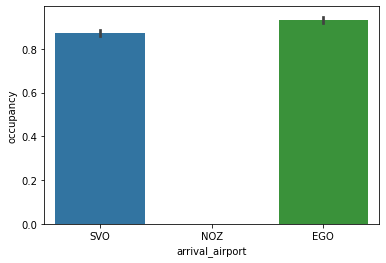

In [562]:
# Рассмотрим зависимость заполняемости от аэропорта вылета
sns.barplot(data = df, x = 'arrival_airport', y = 'occupancy')

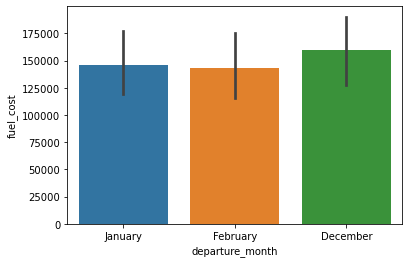

In [563]:
# Рассмотрим зависимость расхода топлива от месяца вылета
sns.barplot(data = df, x = 'departure_month', y = 'fuel_cost')

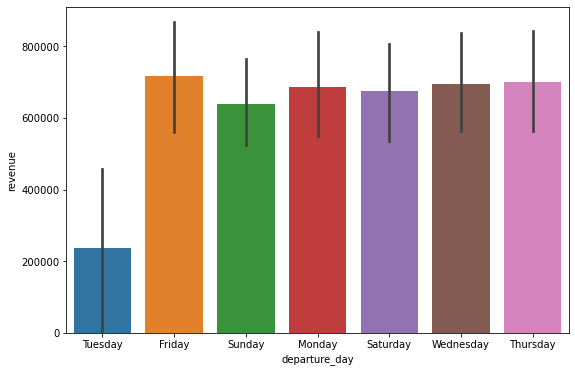

In [564]:
# Рассмотрим зависимость прибыли от дня вылета
f, ax = plt.subplots(figsize=(9, 6))
sns.barplot(data = df, x = 'departure_day', y = 'revenue')


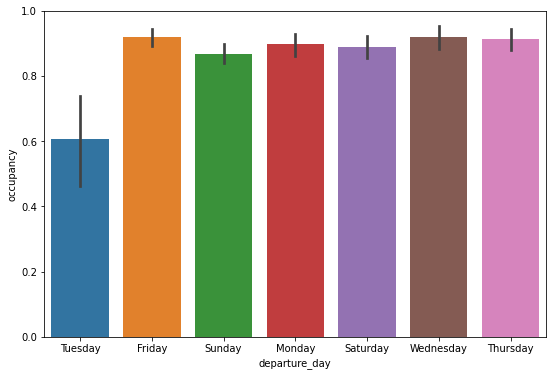

In [565]:
# Рассмотрим зависимость заполняяемости от дня вылета
f, ax = plt.subplots(figsize=(9, 6))
sns.barplot(data = df, x = 'departure_day', y = 'occupancy')

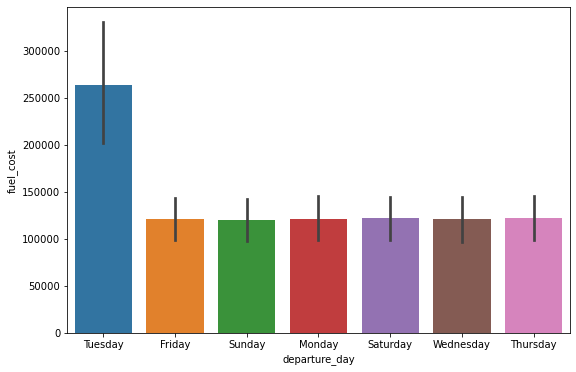

In [566]:
# Рассмотрим зависимость затрат на топливо от дня вылета
f, ax = plt.subplots(figsize=(9, 6))
sns.barplot(data = df, x = 'departure_day', y = 'fuel_cost')

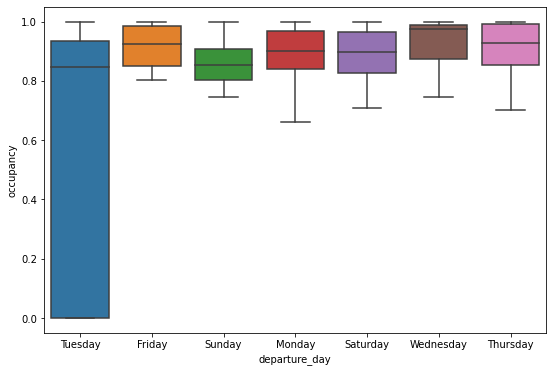

In [567]:
# Рассмотрим зависимость заполняяемости от дня вылета
f, ax = plt.subplots(figsize=(9, 6))
sns.boxplot(data = df, x = 'departure_day', y = 'occupancy')

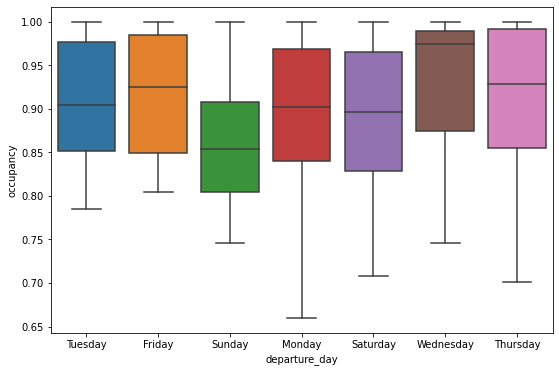

In [568]:
# Рассмотрим зависимость заполняемости рейса от дня вылета, без учета полетов в Новокузнецк
f, ax = plt.subplots(figsize=(9, 6))
sns.boxplot(data = df[df['arrival_airport'] != 'NOZ'], x = 'departure_day', y = 'occupancy')

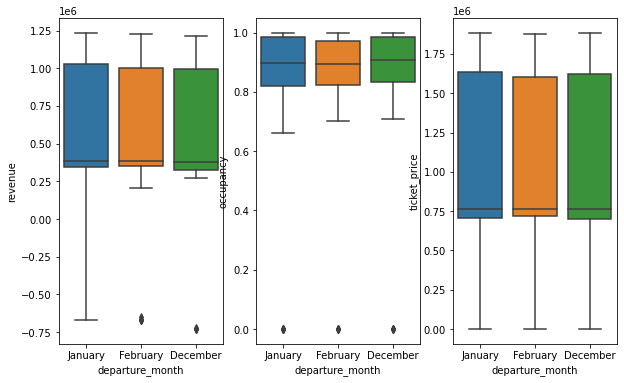

In [569]:
# Рассмотрим зависимость прибыли, заполняемости и сумму проданных билетов от месяца

f, ax = plt.subplots(figsize=(10, 6))
plt.subplot(1, 3, 1)
sns.boxplot(data = df, x = 'departure_month', y = 'revenue')
plt.subplot(1, 3, 2)
sns.boxplot(data = df, x = 'departure_month', y = 'occupancy')
plt.subplot(1, 3, 3)
sns.boxplot(data = df, x = 'departure_month', y = 'ticket_price')

[Text(0, 0.5, ''), Text(0.5, 0, '')]

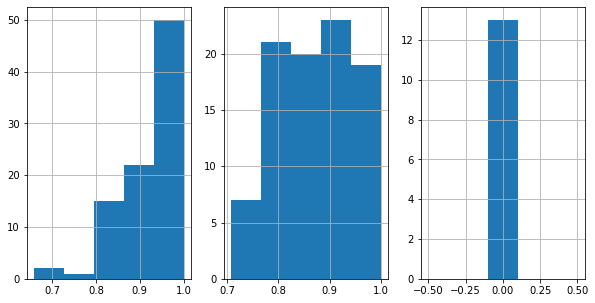

In [570]:
# Построим гистограмму заполняемости по направлениям

f, ax = plt.subplots(figsize=(10, 5))
plt.subplot(1, 3, 1)
df[df['arrival_airport']=='EGO'] .occupancy.hist(bins=5)
plt.subplot(1, 3, 2)
df[df['arrival_airport']=='SVO'] .occupancy.hist(bins=5)
plt.subplot(1, 3, 3)
df[df['arrival_airport']=='NOZ'] .occupancy.hist(bins=5)
ax.set(ylabel="",xlabel="")

In [571]:
# Построим таблицу корреляции всего датасета, наложим тепловую карту.

corr = df.corr()

cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,flight_id,range,ticket_price,seats_occupied,seats_total,distance,fuel_cost,max_flight_weight,airport_fares,occupancy,revenue
flight_id,1.00,-0.88,-0.74,-0.33,-0.88,-0.32,-0.43,-0.88,-0.41,0.12,-0.61
range,-0.88,1.00,0.66,0.15,1.00,0.58,0.68,1.00,0.24,-0.35,0.48
ticket_price,-0.74,0.66,1.00,0.84,0.66,-0.21,-0.09,0.66,0.88,0.46,0.98
seats_occupied,-0.33,0.15,0.84,1.00,0.15,-0.69,-0.59,0.15,0.99,0.87,0.93
seats_total,-0.88,1.00,0.66,0.15,1.00,0.58,0.68,1.00,0.24,-0.35,0.48
distance,-0.32,0.58,-0.21,-0.69,0.58,1.00,0.99,0.58,-0.63,-0.93,-0.42
fuel_cost,-0.43,0.68,-0.09,-0.59,0.68,0.99,1.00,0.68,-0.53,-0.89,-0.30
max_flight_weight,-0.88,1.00,0.66,0.15,1.00,0.58,0.68,1.00,0.24,-0.35,0.48
airport_fares,-0.41,0.24,0.88,0.99,0.24,-0.63,-0.53,0.24,1.00,0.82,0.96
occupancy,0.12,-0.35,0.46,0.87,-0.35,-0.93,-0.89,-0.35,0.82,1.00,0.63


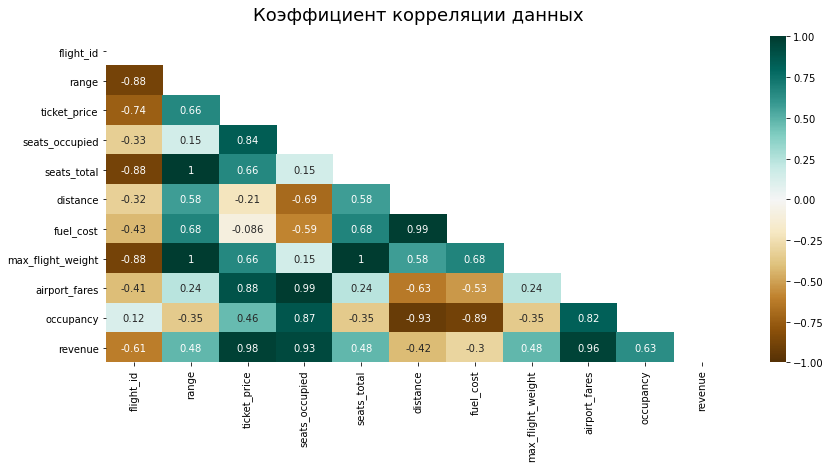

In [572]:
# Преобразуем таблицу в треугольник корреляции, поменяем цвета и подпишем данные для презентации

plt.figure(figsize=(14, 6)) 
mask = np.triu(np.ones_like(corr, dtype = 'bool'))
heatmap = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG') 
heatmap.set_title('Коэффициент корреляции данных', fontdict={'fontsize':18}, pad=16);
plt.savefig('corr_airports.png', dpi=300, bbox_inches='tight')

Выводы:
    Рейсы в Новокузнецк приносят убытки. Необходимо дополнить данные, чтобы точнее оценить ущерб и пересмотреть 
    график вылетов в этом направлении.

In [607]:
round(df[['flight_no','revenue']].groupby(['flight_no']).mean(),0).revenue

flight_no
PG0194    -680728.0
PG0252    1030289.0
PG0480     343590.0
Name: revenue, dtype: float64

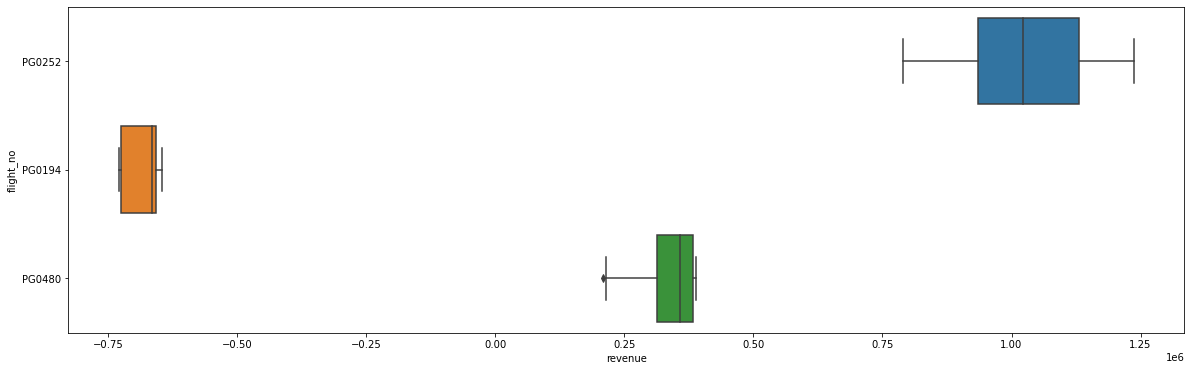

In [599]:
plt.figure(figsize=(20, 6)) 
sns.boxplot(data = df, y="flight_no", x="revenue")
plt.savefig('avg_revenues.png', dpi=300, bbox_inches='tight')

In [610]:
round(df[['flight_no','revenue']].groupby(['flight_no']).mean().revenue.mean(),0)

231051.0